# 📊 EDA AMRS BETA1 - Mean Reversion Strategy

**Análisis Exploratorio parametrizable para optimización de filtros**

## 🎯 Objetivos:
- Analizar distribución de |+DI - -DI| vs resultados WIN/LOSS
- Encontrar filtro DI óptimo para maximizar expectancia
- Validar robustez cross-market (múltiples pares/timeframes)
- Generar recomendaciones para config.py

## ⚙️ CONFIGURACIÓN - Cambiar aquí para probar diferentes pares/timeframes

In [23]:
# ============================================================================
# CONFIGURACIÓN - CAMBIAR AQUÍ PARA PROBAR DIFERENTES PARES/TIMEFRAMES
# ============================================================================

# Par y timeframe a analizar
SYMBOL = "USDJPY"  # "EURUSD", "GBPUSD", "USDJPY", etc.
TIMEFRAME = "H1"   # "H1", "H4", "H6", "D1", etc.

# Filtros a probar (bins para análisis)
DI_BINS = [0, 12, 15, 18, 20, 23, 25, 30, 50]
CURRENT_FILTER = 20  # Filtro actual en uso

print(f"🎯 Configuración:")
print(f"   Par: {SYMBOL}")
print(f"   Timeframe: {TIMEFRAME}")
print(f"   Filtro actual: DI < {CURRENT_FILTER}")

🎯 Configuración:
   Par: USDJPY
   Timeframe: H1
   Filtro actual: DI < 20


## 📚 Imports y Setup

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from datetime import datetime

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
plt.style.use('default')
sns.set_palette('husl')

print("✅ Librerías cargadas")

✅ Librerías cargadas


## 📂 Data Loading - Carga simple y directa

In [31]:
# Cargar archivos directamente (cambiar rutas si es necesario)
df_market = pd.read_csv(f"../Data/{SYMBOL}_{TIMEFRAME}_2019-2025_processed.csv")
df_setups = pd.read_csv("../results/setups_USDJPY_H1_20190101_20251017.csv")

# Convertir fechas
df_market['datetime'] = pd.to_datetime(df_market['datetime'])
df_setups['entry_date'] = pd.to_datetime(df_setups['entry_date'])

print(f"✅ Datos cargados:")
print(f"   Market data: {len(df_market)} velas")
print(f"   Setups: {len(df_setups)} trades")
print(f"   Período market: {df_market['datetime'].min()} - {df_market['datetime'].max()}")
print(f"   Win rate base: {(df_setups['outcome'] == 'WIN').mean() * 100:.1f}%")

✅ Datos cargados:
   Market data: 42386 velas
   Setups: 1195 trades
   Período market: 2019-01-03 02:00:00 - 2025-10-24 23:00:00
   Win rate base: 27.9%


## 🔄 Data Merging - Combinación correcta de datos

In [34]:
# ============================================================================
# DATA PREPARATION - Los setups YA incluyen todos los indicadores
# ============================================================================

# Usar setups directamente (ya tienen indicadores del momento de entrada)
df = df_setups.copy()

# Crear columna DI spread
df['di_spread'] = abs(df['plus_di'] - df['minus_di'])

# Validar datos
print(f"📊 Datos preparados:")
print(f"   Setups con indicadores: {len(df)}")
print(f"   Rango fechas: {df['entry_date'].min()} - {df['entry_date'].max()}")

# Verificar columnas disponibles
print(f"✅ Columnas de indicadores disponibles:")
indicator_cols = ['plus_di', 'minus_di', 'adx', 'rsi', 'atr', 'di_spread']
for col in indicator_cols:
    if col in df.columns:
        print(f"   {col}: ✅")
    else:
        print(f"   {col}: ❌ Falta")

# Mostrar primeras filas
display(df[['entry_date', 'direction', 'outcome', 'result_pips', 'plus_di', 'minus_di', 'di_spread']].head())

📊 Datos preparados:
   Setups con indicadores: 1195
   Rango fechas: 2019-01-09 17:00:00 - 2025-10-16 19:00:00
✅ Columnas de indicadores disponibles:
   plus_di: ✅
   minus_di: ✅
   adx: ✅
   rsi: ✅
   atr: ✅
   di_spread: ✅


,entry_date,direction,outcome,result_pips,plus_di,minus_di,di_spread
0,2019-01-09 17:00:00,LONG,LOSS,-10.6,16.19,32.36,16.17
1,2019-01-15 06:00:00,SHORT,LOSS,-8.2,30.36,12.76,17.60
2,2019-01-16 23:00:00,SHORT,WIN,23.9,28.23,10.46,17.77
3,2019-01-17 22:00:00,SHORT,LOSS,-10.6,29.61,12.33,17.28
4,2019-01-22 11:00:00,LONG,LOSS,-6.5,8.41,26.01,17.60


## 📈 Análisis de DI Spread - Distribución y win rates

📊 Distribución DI Spread |+DI - -DI| GENERAL:
   Min: 0.13
   Max: 68.33
   Media: 19.58
   Mediana: 19.03
   P25: 15.57
   P75: 22.51

📊 Estadísticas DI Spread por Resultado:
------------------------------------------------------------
🟢 WINS (334 setups):
   Media: 16.76
   Mediana: 17.06
   P25: 13.82
   P75: 20.00

🔴 LOSSES (861 setups):
   Media: 20.67
   Mediana: 19.90
   P25: 16.42
   P75: 23.83

📈 COMPARACIÓN:
   Diferencia de medias: +3.91 (losses - wins)
   Diferencia de medianas: +2.84 (losses - wins)


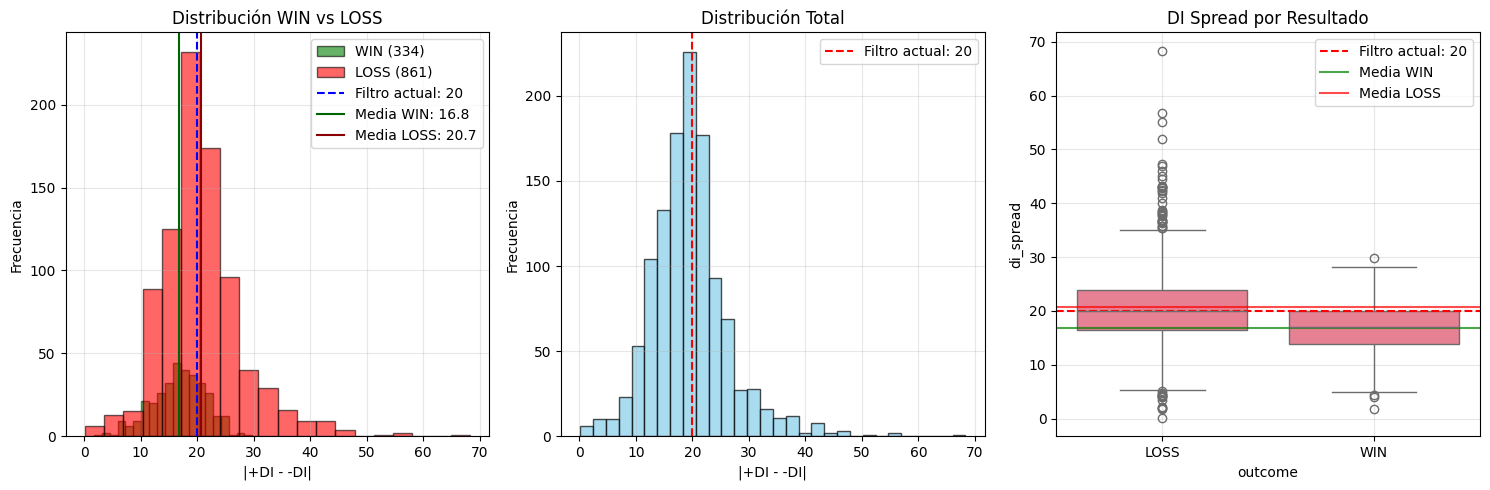

In [37]:
# Estadísticas básicas DI spread GENERAL
print(f"📊 Distribución DI Spread |+DI - -DI| GENERAL:")
print(f"   Min: {df['di_spread'].min():.2f}")
print(f"   Max: {df['di_spread'].max():.2f}")
print(f"   Media: {df['di_spread'].mean():.2f}")
print(f"   Mediana: {df['di_spread'].median():.2f}")
print(f"   P25: {df['di_spread'].quantile(0.25):.2f}")
print(f"   P75: {df['di_spread'].quantile(0.75):.2f}")

# NUEVO: Estadísticas separadas WIN vs LOSS
print(f"\n📊 Estadísticas DI Spread por Resultado:")
print("-" * 60)

wins_di = df[df['outcome'] == 'WIN']['di_spread']
losses_di = df[df['outcome'] == 'LOSS']['di_spread']

print(f"🟢 WINS ({len(wins_di)} setups):")
print(f"   Media: {wins_di.mean():.2f}")
print(f"   Mediana: {wins_di.median():.2f}")
print(f"   P25: {wins_di.quantile(0.25):.2f}")
print(f"   P75: {wins_di.quantile(0.75):.2f}")

print(f"\n🔴 LOSSES ({len(losses_di)} setups):")
print(f"   Media: {losses_di.mean():.2f}")
print(f"   Mediana: {losses_di.median():.2f}")
print(f"   P25: {losses_di.quantile(0.25):.2f}")
print(f"   P75: {losses_di.quantile(0.75):.2f}")

print(f"\n📈 COMPARACIÓN:")
print(f"   Diferencia de medias: {losses_di.mean() - wins_di.mean():+.2f} (losses - wins)")
print(f"   Diferencia de medianas: {losses_di.median() - wins_di.median():+.2f} (losses - wins)")

# Histograma mejorado y boxplot
plt.figure(figsize=(15, 5))

# Histograma superpuesto WIN vs LOSS
plt.subplot(1, 3, 1)
plt.hist(wins_di, bins=20, alpha=0.6, color='green', label=f'WIN ({len(wins_di)})', edgecolor='black')
plt.hist(losses_di, bins=20, alpha=0.6, color='red', label=f'LOSS ({len(losses_di)})', edgecolor='black')
plt.axvline(CURRENT_FILTER, color='blue', linestyle='--', label=f'Filtro actual: {CURRENT_FILTER}')
plt.axvline(wins_di.mean(), color='darkgreen', linestyle='-', label=f'Media WIN: {wins_di.mean():.1f}')
plt.axvline(losses_di.mean(), color='darkred', linestyle='-', label=f'Media LOSS: {losses_di.mean():.1f}')
plt.xlabel('|+DI - -DI|')
plt.ylabel('Frecuencia')
plt.title('Distribución WIN vs LOSS')
plt.legend()
plt.grid(alpha=0.3)

# Histograma general (original)
plt.subplot(1, 3, 2)
plt.hist(df['di_spread'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(CURRENT_FILTER, color='red', linestyle='--', label=f'Filtro actual: {CURRENT_FILTER}')
plt.xlabel('|+DI - -DI|')
plt.ylabel('Frecuencia')
plt.title('Distribución Total')
plt.legend()
plt.grid(alpha=0.3)

# Boxplot WIN vs LOSS
plt.subplot(1, 3, 3)
sns.boxplot(x='outcome', y='di_spread', data=df)
plt.axhline(CURRENT_FILTER, color='red', linestyle='--', label=f'Filtro actual: {CURRENT_FILTER}')
plt.axhline(wins_di.mean(), color='green', linestyle='-', alpha=0.7, label=f'Media WIN')
plt.axhline(losses_di.mean(), color='red', linestyle='-', alpha=0.7, label=f'Media LOSS')
plt.title('DI Spread por Resultado')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 Win Rate por Bins - Análisis de umbrales óptimos

In [17]:
# Crear bins de DI spread
df['di_bin'] = pd.cut(df['di_spread'], bins=DI_BINS, include_lowest=True)

# Análisis por bins
bin_analysis = df.groupby('di_bin').agg({
    'outcome': ['count', lambda x: (x == 'WIN').sum(), lambda x: (x == 'WIN').mean() * 100],
    'result_pips': ['mean', 'std']
}).round(2)

# Renombrar columnas
bin_analysis.columns = ['Total_Trades', 'Wins', 'Win_Rate_%', 'Avg_Pips', 'Std_Pips']
bin_analysis['Losses'] = bin_analysis['Total_Trades'] - bin_analysis['Wins']

# Reordenar columnas
bin_analysis = bin_analysis[['Total_Trades', 'Wins', 'Losses', 'Win_Rate_%', 'Avg_Pips', 'Std_Pips']]

print(f"📊 Win Rate por rangos de DI Spread:")
display(bin_analysis)

📊 Win Rate por rangos de DI Spread:


,Total_Trades,Wins,Losses,Win_Rate_%,Avg_Pips,Std_Pips
di_bin,,,,,,
"(-0.001, 12.0]",18,9,9,50.00,25.99,63.73
"(12.0, 15.0]",40,13,27,32.50,8.69,55.77
"(15.0, 18.0]",70,21,49,30.00,3.96,57.70
"(18.0, 20.0]",52,16,36,30.77,-1.18,46.77
"(20.0, 23.0]",64,20,44,31.25,0.43,56.24
"(23.0, 25.0]",16,1,15,6.25,-13.87,41.70
"(25.0, 30.0]",35,5,30,14.29,-5.05,52.43
"(30.0, 50.0]",13,1,12,7.69,-27.31,36.48


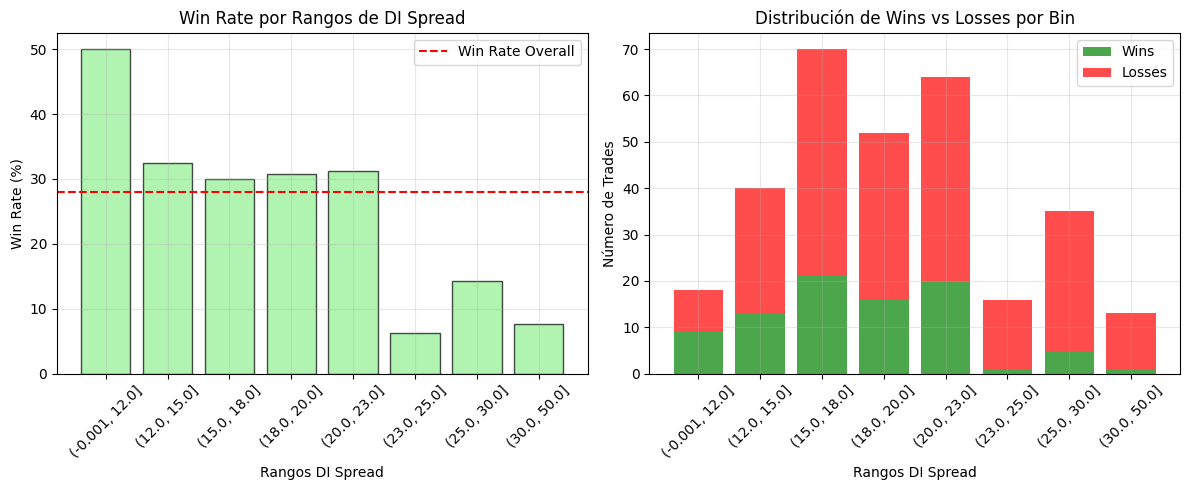

In [19]:
# Gráfico de win rate por bins
plt.figure(figsize=(12, 5))

# Win rate por bin
plt.subplot(1, 2, 1)
bin_labels = [str(b) for b in bin_analysis.index]
plt.bar(bin_labels, bin_analysis['Win_Rate_%'], color='lightgreen', alpha=0.7, edgecolor='black')
plt.axhline(df['outcome'].eq('WIN').mean() * 100, color='red', linestyle='--', label='Win Rate Overall')
plt.xlabel('Rangos DI Spread')
plt.ylabel('Win Rate (%)')
plt.title('Win Rate por Rangos de DI Spread')
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)

# Distribución de trades por bin
plt.subplot(1, 2, 2)
bottom = np.zeros(len(bin_analysis))
plt.bar(bin_labels, bin_analysis['Wins'], label='Wins', color='green', alpha=0.7)
plt.bar(bin_labels, bin_analysis['Losses'], bottom=bin_analysis['Wins'], label='Losses', color='red', alpha=0.7)
plt.xlabel('Rangos DI Spread')
plt.ylabel('Número de Trades')
plt.title('Distribución de Wins vs Losses por Bin')
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 🧮 Análisis de Filtros - Comparación de diferentes umbrales

In [21]:
def calculate_metrics(df_input):
    """
    Calcula métricas completas para un DataFrame de setups
    """
    if len(df_input) == 0:
        return {
            'Trades': 0, 'Win_Rate_%': 0, 'Avg_Win_pips': 0, 
            'Avg_Loss_pips': 0, 'Expectancy_pips': 0, 'Profit_Factor': 0
        }
    
    wins = df_input[df_input['outcome'] == 'WIN']
    losses = df_input[df_input['outcome'] == 'LOSS']
    
    total = len(df_input)
    win_rate = len(wins) / total * 100
    avg_win = wins['result_pips'].mean() if len(wins) > 0 else 0
    avg_loss = losses['result_pips'].mean() if len(losses) > 0 else 0
    expectancy = (win_rate/100) * avg_win + (1 - win_rate/100) * avg_loss
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    return {
        'Trades': total,
        'Win_Rate_%': round(win_rate, 2),
        'Avg_Win_pips': round(avg_win, 2),
        'Avg_Loss_pips': round(avg_loss, 2),
        'Expectancy_pips': round(expectancy, 2),
        'Profit_Factor': round(profit_factor, 2)
    }

# Probar diferentes filtros
filter_thresholds = [12, 15, 18, 20, 23, 25, 30]
filter_results = []

for threshold in filter_thresholds:
    filtered_df = df[df['di_spread'] < threshold]
    metrics = calculate_metrics(filtered_df)
    metrics['Filter_Threshold'] = f"< {threshold}"
    filter_results.append(metrics)

# Agregar métricas sin filtro
no_filter = calculate_metrics(df)
no_filter['Filter_Threshold'] = "Sin filtro"
filter_results.insert(0, no_filter)

# Crear DataFrame comparativo
comparison_df = pd.DataFrame(filter_results)
comparison_df = comparison_df[['Filter_Threshold', 'Trades', 'Win_Rate_%', 'Avg_Win_pips', 
                               'Avg_Loss_pips', 'Expectancy_pips', 'Profit_Factor']]

print(f"📊 Comparación de filtros DI:")
display(comparison_df)

📊 Comparación de filtros DI:


,Filter_Threshold,Trades,Win_Rate_%,Avg_Win_pips,Avg_Loss_pips,Expectancy_pips,Profit_Factor
0,Sin filtro,308,27.92,76.50,-28.26,0.99,2.71
1,< 12,18,50.00,79.17,-27.18,25.99,2.91
2,< 15,58,37.93,78.07,-25.05,14.06,3.12
3,< 18,126,33.33,79.94,-27.81,8.11,2.87
4,< 20,180,32.78,74.69,-27.89,5.73,2.68
5,< 23,244,32.38,73.65,-28.84,4.34,2.55
6,< 25,259,30.89,74.43,-28.50,3.29,2.61
7,< 30,295,28.81,76.40,-27.78,2.24,2.75


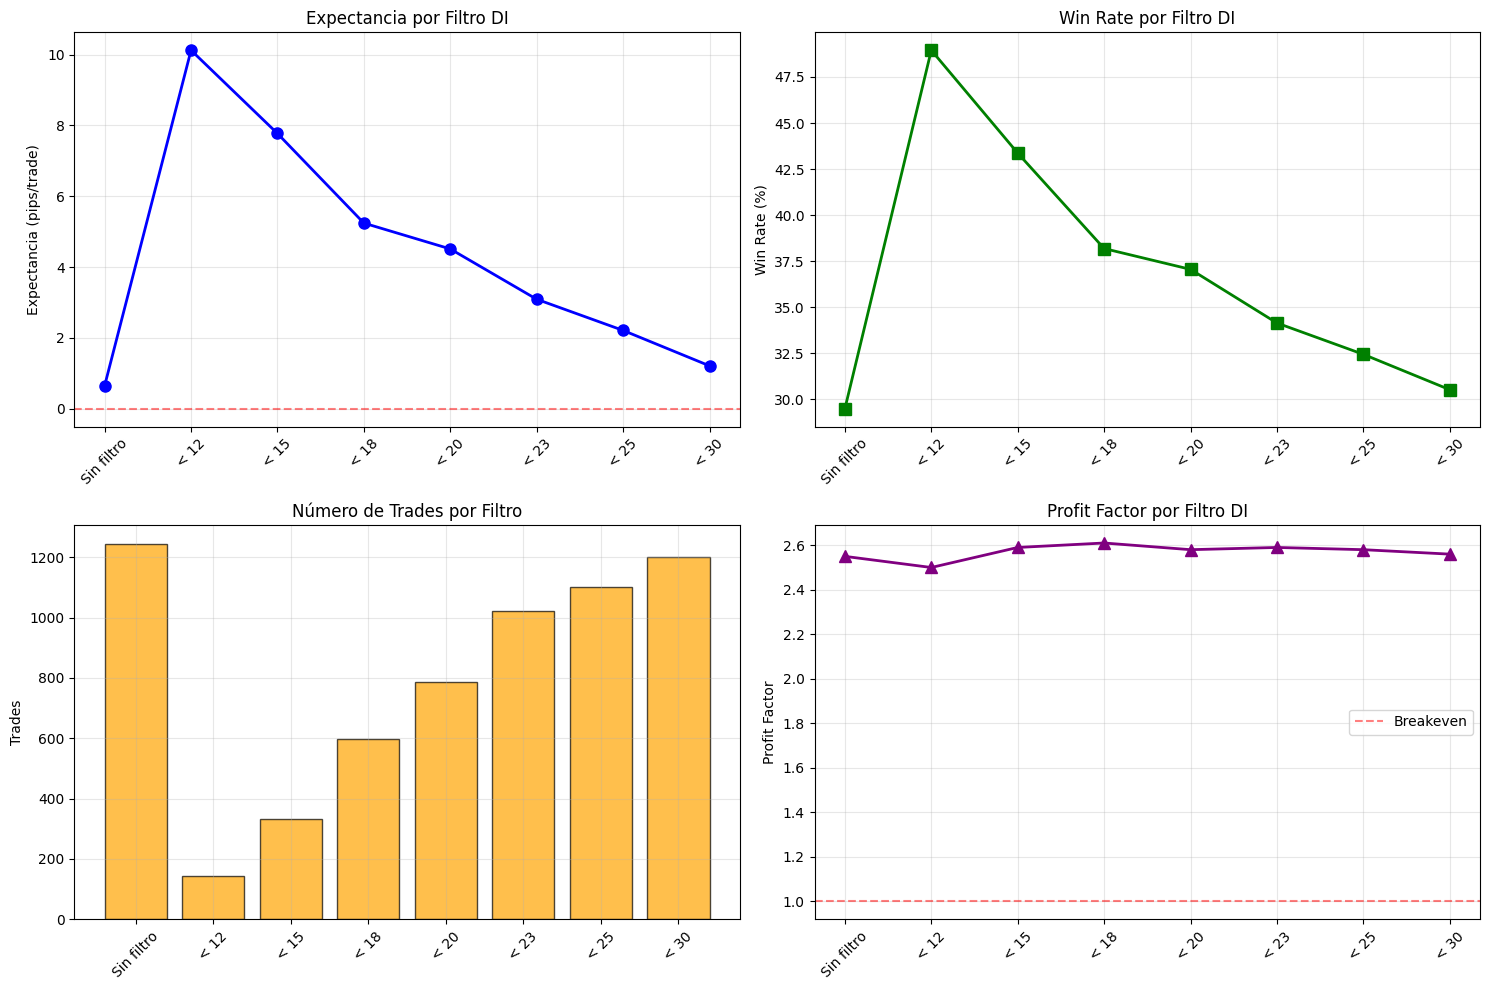

In [81]:
# Visualización de métricas por filtro
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Expectancia por filtro
axes[0,0].plot(comparison_df['Filter_Threshold'], comparison_df['Expectancy_pips'], 
               marker='o', linewidth=2, markersize=8, color='blue')
axes[0,0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0,0].set_title('Expectancia por Filtro DI')
axes[0,0].set_ylabel('Expectancia (pips/trade)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(alpha=0.3)

# Win Rate por filtro
axes[0,1].plot(comparison_df['Filter_Threshold'], comparison_df['Win_Rate_%'], 
               marker='s', linewidth=2, markersize=8, color='green')
axes[0,1].set_title('Win Rate por Filtro DI')
axes[0,1].set_ylabel('Win Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(alpha=0.3)

# Número de trades por filtro
axes[1,0].bar(comparison_df['Filter_Threshold'], comparison_df['Trades'], 
              alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('Número de Trades por Filtro')
axes[1,0].set_ylabel('Trades')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(alpha=0.3)

# Profit Factor por filtro
axes[1,1].plot(comparison_df['Filter_Threshold'], comparison_df['Profit_Factor'], 
               marker='^', linewidth=2, markersize=8, color='purple')
axes[1,1].axhline(1, color='red', linestyle='--', alpha=0.5, label='Breakeven')
axes[1,1].set_title('Profit Factor por Filtro DI')
axes[1,1].set_ylabel('Profit Factor')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 🏆 Recomendaciones Finales

In [33]:
# Encontrar filtro óptimo por expectancia
filtered_comparison = comparison_df[comparison_df['Filter_Threshold'] != 'Sin filtro']
best_filter_idx = filtered_comparison['Expectancy_pips'].idxmax()
best_filter = filtered_comparison.loc[best_filter_idx]

# Comparar con situación actual
current_filter_row = comparison_df[comparison_df['Filter_Threshold'] == f'< {CURRENT_FILTER}']
current_metrics = current_filter_row.iloc[0] if not current_filter_row.empty else None

print(f"🏆 ANÁLISIS DE OPTIMIZACIÓN - {SYMBOL} {TIMEFRAME}")
print("=" * 60)

print(f"\n📊 FILTRO ÓPTIMO ENCONTRADO:")
print(f"   Threshold: {best_filter['Filter_Threshold']}")
print(f"   Expectancia: {best_filter['Expectancy_pips']:+.2f} pips/trade")
print(f"   Win Rate: {best_filter['Win_Rate_%']:.1f}%")
print(f"   Trades: {best_filter['Trades']:.0f}")
print(f"   Profit Factor: {best_filter['Profit_Factor']:.2f}")

if current_metrics is not None:
    print(f"\n📈 COMPARACIÓN vs FILTRO ACTUAL (<{CURRENT_FILTER}):")
    exp_improvement = ((best_filter['Expectancy_pips'] - current_metrics['Expectancy_pips']) / 
                       abs(current_metrics['Expectancy_pips']) * 100) if current_metrics['Expectancy_pips'] != 0 else 0
    wr_improvement = best_filter['Win_Rate_%'] - current_metrics['Win_Rate_%']
    trades_change = best_filter['Trades'] - current_metrics['Trades']
    
    print(f"   Expectancia: {current_metrics['Expectancy_pips']:+.2f} → {best_filter['Expectancy_pips']:+.2f} pips/trade ({exp_improvement:+.1f}%)")
    print(f"   Win Rate: {current_metrics['Win_Rate_%']:.1f}% → {best_filter['Win_Rate_%']:.1f}% ({wr_improvement:+.1f}pp)")
    print(f"   Trades: {current_metrics['Trades']:.0f} → {best_filter['Trades']:.0f} ({trades_change:+.0f})")

print(f"\n⚙️ CONFIGURACIÓN RECOMENDADA para config.py:")
optimal_value = int(best_filter['Filter_Threshold'].split('<')[1].strip())
print(f"   DI_SPREAD_MAX = {optimal_value}")

# Expectativa anual estimada
if TIMEFRAME == "H1":
    trades_per_year = best_filter['Trades'] / 6.8 * (365 * 24 / (365 * 24))  # Aproximación
elif TIMEFRAME == "H4":
    trades_per_year = best_filter['Trades'] / 6.8 * (365 * 6 / (365 * 24))  # Aproximación
else:
    trades_per_year = best_filter['Trades'] / 6.8  # Estimación general

annual_expectancy = best_filter['Expectancy_pips'] * trades_per_year
print(f"\n💰 PROYECCIÓN ANUAL:")
print(f"   ~{trades_per_year:.0f} trades/año")
print(f"   ~{annual_expectancy:+.0f} pips/año")

if best_filter['Expectancy_pips'] > 5:
    print(f"\n🟢 VEREDICTO: EXCELENTE estrategia")
elif best_filter['Expectancy_pips'] > 2:
    print(f"\n🟡 VEREDICTO: PROMETEDORA estrategia")
elif best_filter['Expectancy_pips'] > 0:
    print(f"\n⚠️ VEREDICTO: MARGINAL estrategia")
else:
    print(f"\n❌ VEREDICTO: NO VIABLE estrategia")

# Guardar análisis
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_file = f"../results/eda_analysis_{SYMBOL}_{TIMEFRAME}_{timestamp}.csv"
comparison_df.to_csv(output_file, index=False)
print(f"\n💾 Análisis guardado: {output_file}")

🏆 ANÁLISIS DE OPTIMIZACIÓN - GBPUSD H4

📊 FILTRO ÓPTIMO ENCONTRADO:
   Threshold: < 12
   Expectancia: +10.73 pips/trade
   Win Rate: 50.0%
   Trades: 156
   Profit Factor: 2.54

📈 COMPARACIÓN vs FILTRO ACTUAL (<20):
   Expectancia: +6.49 → +10.73 pips/trade (+65.3%)
   Win Rate: 40.5% → 50.0% (+9.5pp)
   Trades: 772 → 156 (-616)

⚙️ CONFIGURACIÓN RECOMENDADA para config.py:
   DI_SPREAD_MAX = 12

💰 PROYECCIÓN ANUAL:
   ~6 trades/año
   ~+62 pips/año

🟢 VEREDICTO: EXCELENTE estrategia

💾 Análisis guardado: ../results/eda_analysis_GBPUSD_H4_20251107_1734.csv
